In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

import re
import pymorphy2
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [99]:
messages = pd.read_csv('myf.csv')

In [100]:
TOKEN_RE = re.compile(r'[а-яё]+')
russian_stopwords = stopwords.words("russian")
lemmatizer = pymorphy2.MorphAnalyzer()

def tokenize_text(txt, min_lenght_token=2):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_lenght_token]

def remove_stopwords(tokens):
    return list(filter(lambda token: token not in russian_stopwords, tokens))

def lemmatizing(tokens):
    return [lemmatizer.parse(token)[0].normal_form for token in tokens]

def text_cleaning(txt):
    tokens = tokenize_text(txt)
    tokens  = lemmatizing(tokens)
    tokens = remove_stopwords(tokens)
    return ' '.join(tokens)

In [101]:
tqdm.pandas()

df_token = df.copy()
df_token['message'] = df_token['message'].progress_apply(text_cleaning)
df_token.dropna()
df_token.head()

100%|███████████████████████████████████████████████████████████████████████████████| 916/916 [00:01<00:00, 509.37it/s]


,message,label
0,открыть новый место спрос рождать расширение е...,1
1,ещё написать че ждать твой бабка ждать,1
2,работа америкать бро это высокий зп возможност...,1
3,сало брат связь америкать искать поднять прили...,1
4,дорога друг попасть сюда случайно искать качес...,1


In [102]:
df = df_token.copy()
empty = df[df['message'] == '']
print('Number of empty texts: ', len(empty))
df = df.drop(empty.index)

Number of empty texts:  0


In [103]:
df = df.drop_duplicates()

In [104]:
df['label'] = 1
df.head()

,message,label
0,открыть новый место спрос рождать расширение е...,1
1,ещё написать че ждать твой бабка ждать,1
2,работа америкать бро это высокий зп возможност...,1
3,сало брат связь америкать искать поднять прили...,1
4,дорога друг попасть сюда случайно искать качес...,1


In [105]:
df.to_csv('lab.csv')

In [106]:
import pandas as pd
  
f_df = pd.concat(
    map(pd.read_csv, ['lab.csv', 'rand.csv']), ignore_index=True)
f_df.drop('Unnamed: 0', inplace=True, axis=1)
print(f_df)

                                                message  label
0     открыть новый место спрос рождать расширение е...      1
1                ещё написать че ждать твой бабка ждать      1
2     работа америкать бро это высокий зп возможност...      1
3     сало брат связь америкать искать поднять прили...      1
4     дорога друг попасть сюда случайно искать качес...      1
...                                                 ...    ...
6911                                БОРЩ или или =)) ??      0
6912  Мальчишки и девчонки!!А подарите мне на День Р...      0
6913  никогда не перестану рыдать пересматривая этот...      0
6914  Отлично погуляли *\nБыло очень весело ~\nСпаси...      0
6915              дашечка, нормально? ты не расстроена?      0

[6916 rows x 2 columns]


In [107]:
from sklearn.utils import shuffle
df_shuffled = shuffle(f_df)

In [108]:
df_train, df_test = train_test_split(df_shuffled, 
                                     random_state=311, 
                                     test_size=0.33, 
                                     stratify=df_shuffled['label']
                                    )

train_corpus = df_train['message'].values
test_corpus = df_test['message'].values

y_train = df_train['label']
y_test = df_test['label']

In [109]:
vectorizer = TfidfVectorizer(ngram_range=(2,4), analyzer='char_wb', max_df=0.8, min_df=10)
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)

print('Total features: ', len(vectorizer.get_feature_names()))

Total features:  9653


In [110]:
Logregres = LogisticRegression(max_iter=10000, C=3, solver='liblinear')
Logregres.fit(X_train, y_train)
y_pred = Logregres.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1981
           1       0.98      0.78      0.87       302

    accuracy                           0.97      2283
   macro avg       0.97      0.89      0.93      2283
weighted avg       0.97      0.97      0.97      2283



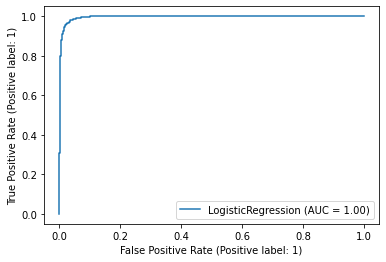

In [111]:
plot_roc_curve(Logregres, X_test, y_test)
plt.show()

In [112]:
message = "Ваша задача делать тайники по городу! ВАМ НУЖНО  ПРОСТО ОСТАВЛЯТЬ ЗАГОТОВКУ В ЛЮБОМ  МЕСТЕ - И СДАВАТЬ КУРАТОРУ ПОДРОБНОЕ ОПИСАНИЕ ГДЕ ОТСТАВИЛИ ИЛИ СДАВАТЬ АДРЕСА МОЖЕТЕ ЧЕРЕЗ КООРДИНАТЫ . "
clean_message = text_cleaning(message)
X_example = vectorizer.transform([clean_message])
probabality = Logregres.predict_proba(X_example)[0,1]
print(f'Probability: {probabality:.2f}')

Probability: 0.96


In [114]:
import telebot
import PIL
from PIL import Image
from requests import get


bot = telebot.TeleBot('5454220634:AAFqPAzXeeI4f_ME7D4UXD2TmrIDvxRgavU')

@bot.message_handler(commands=['start'])
def start_message(message):
    bot.send_message(message.chat.id, 'Пришлите потенциально опасный текст')
                     
@bot.message_handler(content_types=['text'])
def send_text(message):
    lines = message.text
    clean_message = text_cleaning(lines)
    X_example = vectorizer.transform([clean_message])
    probabality = Logregres.predict_proba(X_example)[0,1]
    if probabality > 0.6:
        bot.send_message(message.chat.id, 'ОПАСНО')
    else:
        bot.send_message(message.chat.id, 'Безопасно')

bot.polling()

ReadTimeout: HTTPSConnectionPool(host='api.telegram.org', port=443): Read timed out. (read timeout=25)